# B2B TIME SERIES PREDICTION USING SIMPLE RNN

In [5]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
import keras as kr
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import SimpleRNN
import matplotlib.pyplot as plt
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
import io



## Read data from csv file.

In [7]:
data=pd.read_csv('./data_akbilgic_clean.csv', sep=';')

In [8]:

data.reset_index(inplace=True)#index dataset


## Plot ISE

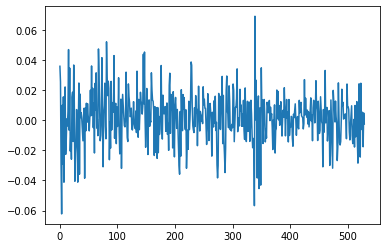

In [9]:
plt.plot(data['ISE'])
plt.show()

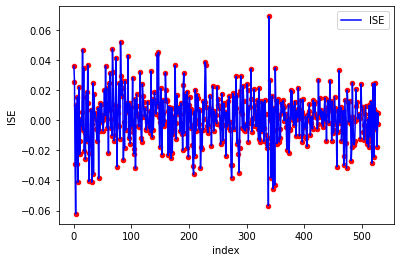

In [10]:
ax = plt.gca()
data.plot(kind='line', x=0,y=1, color='blue', ax=ax)
data.plot(kind='scatter', x=0,y=1, color='red', ax=ax)
plt.show()

In [11]:
df = data['ISE'].to_frame(name='ISE') #isolate ISE feature
print(df.head(3))

        ISE
0  0.035754
1  0.025426
2 -0.028862


## Normalize data

In [12]:

scaler = MinMaxScaler(feature_range=(0, 1))
df = scaler.fit_transform(np.reshape(df['ISE'].values, (df.shape[0], 1)))
df = pd.DataFrame(data=df, columns=['ISE'])

In [13]:
df.head(3)

,ISE
0,0.746889
1,0.668147
2,0.254242


In [14]:
def timeseries_to_supervised(df, n_in, n_out):
   agg = pd.DataFrame()

   for i in range(n_in, 0, -1):
      df_shifted = df.shift(i).copy()
      df_shifted.rename(columns=lambda x: ('%s(t-%d)' % (x, i)), inplace=True)
      agg = pd.concat([agg, df_shifted], axis=1)

   for i in range(0, n_out):
      df_shifted = df.shift(-i).copy()
      if i == 0:
         df_shifted.rename(columns=lambda x: ('%s(t)' % (x)), inplace=True)
      else:
         df_shifted.rename(columns=lambda x: ('%s(t+%d)' % (x, i)), inplace=True)
      agg = pd.concat([agg, df_shifted], axis=1)
   agg.dropna(inplace=True)
   return agg

## Make dataset supervised with timeseries step equals 4

In [15]:
n_in = 4
n_out = 1
sdf = timeseries_to_supervised(df, n_in, n_out)

In [16]:
X, y = sdf[[('ISE(t-%d)' % i) for i in range(4, 0, -1)]].values, sdf['ISE(t)'].values
print(X.shape, y.shape)

(526, 4) (526,)


## Seperate training and testing data.

In [17]:
len_data = X.shape[0]
print(len_data)
train_size = int(len_data * .5)
print ("Train size: %d" % train_size)
print ("Test size: %d" % (len_data - train_size))

xtr, ytr = X[:train_size, :], y[:train_size]
xte, yte = X[train_size:, :], y[train_size:]
print(xtr.shape, ytr.shape)
print(xte.shape, yte.shape)

526
Train size: 263
Test size: 263
(263, 4) (263,)
(263, 4) (263,)


## Convert data to  3d numpy arrays.

In [18]:
samples = train_size
steps = 1
print("Samples",samples)
features_in = 4
features_out = n_out
xtr = np.reshape(xtr, (samples, steps, features_in))# (Samples,steps,input_features)=(263,1,4)
ytr = np.reshape(ytr, (samples, steps, features_out)) # (Samples,steps,output_features)=(263,1,1)
print("Training data input shape:",xtr.shape,"Training data output shape:", ytr.shape)
xte = np.reshape(xte, (samples, steps, features_in))
yte = np.reshape(yte, (samples, steps, features_out))
print("Testing data input shape:",xte.shape,"Testing data output shape:", yte.shape)

Samples 263
Training data input shape: (263, 1, 4) Training data output shape: (263, 1, 1)
Testing data input shape: (263, 1, 4) Testing data output shape: (263, 1, 1)


## Built a Simple RNN regression model.

In [38]:
batch_size = 1 #batch size is 1.The weights are updated 263 times per epoch.
model = Sequential()

model.add(SimpleRNN(units=50, input_shape=(xtr.shape[1], xtr.shape[2]), activation="relu", return_sequences=True))
model.add(Dense(50, activation="relu")) #linear activation functio was tested as well.

model.add(Dense(1, activation="relu")) #one output neuron since it is a regression problem.
model.compile(loss='mean_squared_error', optimizer='adam')#mean squered error is used as loss function.
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_3 (SimpleRNN)     (None, 1, 50)             2750      
_________________________________________________________________
dense_8 (Dense)              (None, 1, 50)             2550      
_________________________________________________________________
dense_9 (Dense)              (None, 1, 1)              51        
Total params: 5,351
Trainable params: 5,351
Non-trainable params: 0
_________________________________________________________________


## Train the model.

In [39]:
model.fit(xtr,ytr, epochs=50, batch_size=batch_size, verbose=2)

Epoch 1/50
263/263 - 2s - loss: 0.0257
Epoch 2/50
263/263 - 0s - loss: 0.0195
Epoch 3/50
263/263 - 0s - loss: 0.0193
Epoch 4/50
263/263 - 0s - loss: 0.0195
Epoch 5/50
263/263 - 0s - loss: 0.0193
Epoch 6/50
263/263 - 0s - loss: 0.0177
Epoch 7/50
263/263 - 0s - loss: 0.0178
Epoch 8/50
263/263 - 0s - loss: 0.0180
Epoch 9/50
263/263 - 0s - loss: 0.0179
Epoch 10/50
263/263 - 0s - loss: 0.0180
Epoch 11/50
263/263 - 0s - loss: 0.0173
Epoch 12/50
263/263 - 0s - loss: 0.0176
Epoch 13/50
263/263 - 0s - loss: 0.0173
Epoch 14/50
263/263 - 0s - loss: 0.0175
Epoch 15/50
263/263 - 0s - loss: 0.0174
Epoch 16/50
263/263 - 0s - loss: 0.0169
Epoch 17/50
263/263 - 0s - loss: 0.0176
Epoch 18/50
263/263 - 0s - loss: 0.0173
Epoch 19/50
263/263 - 0s - loss: 0.0168
Epoch 20/50
263/263 - 0s - loss: 0.0171
Epoch 21/50
263/263 - 0s - loss: 0.0173
Epoch 22/50
263/263 - 0s - loss: 0.0168
Epoch 23/50
263/263 - 0s - loss: 0.0167
Epoch 24/50
263/263 - 0s - loss: 0.0167
Epoch 25/50
263/263 - 0s - loss: 0.0163
Epoch 26/

## Make predictions

In [40]:
trainPredict = model.predict(xtr, batch_size=batch_size)
testPredict = model.predict(xte, batch_size=batch_size)

In [41]:
trainPredict = np.reshape(trainPredict, (samples*steps, features_out))
ytr2d = np.reshape(ytr, (samples*steps, features_out))
testPredict = np.reshape(testPredict, (samples*steps, features_out))
yte2d = np.reshape(yte, (samples*steps, features_out))

## Inverse the normalization of the data.

In [42]:
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform(ytr2d)
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform(yte2d)

In [43]:
print("Test Mean Squared Error: ", mean_squared_error(testY, testPredict))
#print("Test MSE: ", sum(np.square(testY-testPredict))/testY.shape[0])#computed by hand
print("Test Mean Absolute Error: ", sum(abs(testY-testPredict))/testY.shape[0])
print("Test R2 (R-squared.): ", r2_score(testY, testPredict))
#print("Test R2: ", 1-(sum(np.square(testY-testPredict))/sum(np.square(testY-testY.mean()))))#computed by hand

Test Mean Squared Error:  0.00023184320564620362
Test Mean Absolute Error:  [0.01114928]
Test R2 (R-squared.):  -0.07017577011985465


In [44]:
predicted = np.concatenate((trainPredict,testPredict),axis=0)#Concatenate the training and the testing predictions.

## Display the effectiveness of the model. (left side is training and right is testing).

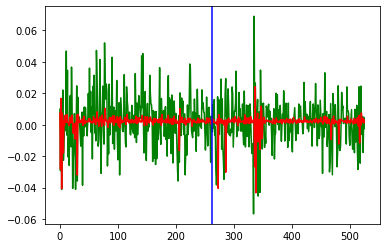

In [46]:
original = np.concatenate((trainY,testY),axis=0)
predicted = np.concatenate((trainPredict,testPredict),axis=0)
index = range(0, original.shape[0])
plt.plot(index,original, 'g')# true predictions
plt.plot(index,predicted, 'r') #model predictions
plt.axvline(df.index[train_size], c="b")
plt.savefig('./rnn_plot.png')
plt.show()